# Modélisation 
### Nous allons effectuer sur ce notebook la partie modélisation en utilisant les features avec une PCA et observer les différents résultats obtenus

In [59]:
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import os
import warnings
import sklearn
import time 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


#preparation des données
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

#mesure performance : 
from sklearn import metrics
warnings.filterwarnings("ignore")

In [60]:
# Lecture des données :
path1 = [i for i in os.getcwd().split("\\")]
path1

['D:',
 'Etude_Data_science',
 'Kaggle_competition',
 '02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals',
 'notebook']

In [61]:
path2 = ("\\").join(path1[:-1]) + "\\dataset"

In [62]:
os.listdir(path2)

['data_cleaned.csv',
 'data_cleaned_PCA.csv',
 'data_cleaned_withoutPCA.csv',
 'playground-series-s3e24.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [63]:
data = pd.read_csv(path2+"\\data_cleaned_PCA.csv", index_col = 0)
df = data.copy()
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,hearing(left),hearing(right),Urine protein,dental caries,smoking
0,-3.606746,0.755803,-1.218238,-0.401488,-0.427850,-0.212524,0.734177,0.772676,-1.172399,0.307489,-0.006818,0.700179,1,1,1,0,1
1,-1.181505,4.401603,-2.490884,-1.117876,0.384461,3.960486,-6.225314,2.274480,-1.635772,3.977569,0.548055,1.063149,2,2,1,1,0
2,-2.731105,-1.048645,-0.828711,0.055921,0.090602,1.316630,1.122125,0.630216,0.379617,-0.711981,0.085530,0.998121,1,1,1,0,1
3,-1.369274,1.904712,0.788166,-1.374263,-0.530577,-0.646030,0.669578,0.086063,-0.155953,-0.352081,0.210692,0.889490,1,1,1,1,0
4,1.614225,-1.958460,-0.953814,-0.379936,0.165742,-0.792837,1.132931,1.293741,-0.738215,-0.599433,0.329744,-0.559030,1,1,1,0,1


In [64]:
df.shape

(159256, 17)

#### Récupération d'un sample du dataframe pour effectuer les différents test de modélisation

##### La colonne sera ensuite mute une fois les tests terminés pour utiliser l'ensemble du dataframe
df = df.sample(1000, random_state=42)

In [65]:
df.shape

(159256, 17)

In [66]:
X,y = df.drop("smoking", axis = 1), df["smoking"]

In [67]:
X_train,X_test,y_train, y_test = train_test_split(X,y, random_state=42,
                                                 test_size=0.2)

# Plan : 

## 1. Création de fonction de modélisation et  Préparation des modèles

## 2. Entrainement des modèles

## 3. Résultats et premières selection de modèles

## 4. Visualisation des autres metrics

## 5. Amélioration des modèles par GridSearchCV

## 6. Visualisation des performances

# 1. Création des fonctions de modélisation et préparation des modèles

In [68]:
all_model = [DummyClassifier(),
             LogisticRegression(),
             KNeighborsClassifier(),
             SGDClassifier(),
             RandomForestClassifier()]

In [69]:
### Création d'une fonction d'entrainement pour un modèle donné

def train_model(model):
    """le modèle sera entrainé par validation score sur 5 split
    et affichage du score moyen.
    la fonction renvoi les prédiction du modèle entrainé et le temps d'entrainement"""
    scores = (cross_val_score(estimator=model, X=X_train,y=y_train, cv=5)).mean()
    print(str(model))
    print("Score moyen validation croisée :", scores.round(2))
    
    # Mesurer le temps de début
    start_time = time.time()
    
    #Entrainement du modele
    model.fit(X_train,y_train)
    
    # Mesurer le temps de fin
    end_time = time.time()
    
    # Calculer la durée totale
    training_time = round(end_time - start_time,2)
    #Convertir la duree en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values) #rajout ici '.values' pour que ca fonctionne avec KNN
    return yp,training_time_min, model

In [70]:
### Création d'une fonction qui renvoi l'ensemble des metrics :

def metric(prediction, model_name, exe_time):
    """Fonction qui renvoie un objet pandas Series contenant les valeurs des metrics
    principales : f1 score, accuracy, recall, precision score et le temps d'execution
    à partir de la liste des prédictions d'un modèle"""
    
    f1 = metrics.f1_score(y_true = y_test, y_pred = prediction)
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = prediction)
    recal = metrics.recall_score(y_true = y_test, y_pred = prediction)
    precision = metrics.precision_score(y_true = y_test, y_pred = prediction)
    
    all_metric = [f1,accuracy,recal,precision, exe_time]
    
    index_metric = ["F1","accuracy","recall","precision","duree_entrainement(min)"]
    
    series = pd.Series(all_metric, name=str(model_name), index=index_metric)
    return pd.DataFrame(series)
    
    

In [71]:
### fonction pour créer une matrice de confusion : 

def matrice_confusion(prediction):
    cf = metrics.confusion_matrix(y_true=y_test, y_pred=prediction)
    plt.figure(figsize=(4,4))
    ax = sns.heatmap(cf, annot = True, linewidths=0.8, linecolor="black", fmt = ".0f",cbar=False, cmap = "Blues")
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Valeurs réelles')
    plt.title("Confusion Matrix")
    plt.show()


In [72]:
### Fonction pour obtenir la learning curve d'un modèle : 
def learning_curv(model):
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                                X_train, y_train, cv=5)
    
# Calcul des scores moyens pour l'apprentissage et la validation
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

# Tracer les courbes d'apprentissage
    plt.figure(figsize=(4, 3))
    plt.plot(train_sizes, train_scores_mean, label='Score d\'entraînement moyen')
    plt.plot(train_sizes, test_scores_mean, label='Score de validation moyen')
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('Score')
    plt.title('Courbes d\'apprentissage')
    plt.legend()
    plt.show()
    


In [73]:
### Fonction pour obtenir la courbe ROC : 

def ROC(prediction):
    FP_rate, TP_rate, thresholds = metrics.roc_curve(y_test,prediction)
    roc_auc = metrics.auc(FP_rate,TP_rate)
    print("ROC_AUC =", roc_auc.round(2))
    
    
    ### Création de la courbe AUC ROC :
    plt.figure(figsize=(6,6))
    
    #Courbe prédictive :
    sns.lineplot(x = FP_rate, y = TP_rate, color = "orange", label = f"AUC = {roc_auc:,.2f}%")
    
    #Courbe random :
    sns.lineplot(x=[0,1],y=[0,1], linestyle = "--", c = "r", label= "Random Classifier")

    plt.ylabel("True Positive rate")
    plt.xlabel("False Positive rate")
    plt.title("ROC")
    plt.legend(loc = "upper left")
    plt.show()

In [74]:
### Fonction permettant d'améliorer un modèle grâce au GridSearchCV :

def Grid(model, param):
    """Le modèle sera entrainé sur 5 splits
    et renverra les prédictions du meilleur modèles ainsi que son temps d'entrainement"""
    
 # Mesurer le temps de début
    start_time = time.time()
        
    #Entrainement du grid sur les paramètres
    grid = GridSearchCV(estimator=model, param_grid=param, cv=5)
    grid.fit(X_train, y_train)
    # Mesurer le temps de fin
    end_time = time.time()
    
    #Recuperation des meilleurs hyper parametres :
    best_model = grid.best_estimator_
    
    # Convertir X_test en un format compatible si nécessaire
    X_test_transformed = X_test.values  

    
    #Recuperation des predictions
    yp = best_model.predict(X_test_transformed)
    
    #Calcul temps d'execution:
    training_time = round(end_time- start_time  , 3)
    #On converti en minutes :
    training_time_min = round(training_time/60,2)
    
    return yp, training_time_min, best_model

## 2. Entrainement des différents modèles et récupération des metrics :
- Nous allons créer une boucle qui va parcourir notre liste des modèles utilisés et qui fera :
    - Entrainement des modèles et récupèrera les prédictions et les temps d'execution
    - Enregistrement du modèle sur le dictionnaire dict_model_trained
    - Ajout des metrics dans le dictionnaire dict_metric
    - ajout des prédiction dans le dictionnaire dict_prediction
    -  enregistrement final dans un dataframe contenant les différentes metrics

In [75]:
save_path = r'D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\Modeles\\'

In [76]:
#Dictionnaire qui contiendra les différentes metrics de chaque modèle
dict_metric = {}

#dictionnaire contenant les valeurs prédictives pour chaque modèles
dict_prediction = {}

#dictionnaire contenant les modele entrainé
dict_model_trained = {}

for current_model in all_model:
    #Recuperation des prédictions et du temps d'execution de chaque modèles
    prediction, temps_exe, model_trained = train_model(current_model)
    
    
    # Récupération du nom du modèle et du chemin d'enregistrement
    model_name = current_model.__class__.__name__
    
    # Enregitrement des modèles après entrainement : 
    dict_model_trained[model_name] = model_trained
    
    
    
    #Enregistrement des prédiction dans le dictionnaire :
    dict_prediction[model_name] = prediction
    
    # Enregistrement des métriques au dictionnaire
    dict_metric[model_name] = metric(prediction=prediction, model_name=model_name, exe_time=temps_exe)

    
#Pour les Dataframe :
    
# Concaténation des métriques en un DataFrame
df_metrics = pd.concat(dict_metric.values(), axis=1)
#intervertissons les colonnes et les indexs :
df_metrics = df_metrics.T
# Enregistrement du DataFrame des métriques
df_metrics.to_csv("df_metrics.csv")


#Enregistrement des prédictions dans un dataframe :
df_prediction = pd.DataFrame(dict_prediction)
# Enregistrement du DataFrame des prédictions
df_prediction.to_csv("df_prediction.csv")


DummyClassifier()
Score moyen validation croisée : 0.56
LogisticRegression()
Score moyen validation croisée : 0.58
KNeighborsClassifier()
Score moyen validation croisée : nan
SGDClassifier()
Score moyen validation croisée : 0.58
RandomForestClassifier()
Score moyen validation croisée : 0.56


In [77]:
#Enregistrement des modèles :

for i in dict_model_trained:
    model_name = i
    current_model = dict_model_trained[model_name]
    
    model_filename = os.path.join(save_path, f"{model_name}.pkl")
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


### 3. Résultats et premières selection de modèles
- Nous allons déja effectuer un premier filtre de modèles en supprimant ceux qui mettent beaucoup trop de temps à s'entrainer

In [78]:
df_metrics.sort_values(by = "F1", ascending=False)

,F1,accuracy,recall,precision,duree_entrainement(min)
KNeighborsClassifier,0.421559,0.524582,0.392210,0.455656,0.00
SGDClassifier,0.331972,0.573685,0.239818,0.539150,0.01
LogisticRegression,0.326209,0.575380,0.232710,0.545303,0.00
RandomForestClassifier,0.325019,0.559902,0.239889,0.503807,4.72
DummyClassifier,0.000000,0.558301,0.000000,0.000000,0.00


#### Observation : 

- On peut voir que le **KNN** est le modèle ayant le **meilleur F1 score**. Autrement dit on a le meilleur ratio **precision/recall** avec un temps d'execution nul.
- SVC et SGD ont des performance proche, sauf que SVC met 30min à s'executer.
- Suivi de très proche par la regression logistic et random forest
- L'ensemble des modèles ont pu s'entrainer lorsqu'on compare au dummyclassifier et donc ont reussi a apprendre

### conclusion :
#### On peut exclure les modèles SVC et RandomforestClassifier qui mettent beaucoup de temps à s'entrainer et qui ne propose pas de performance exceptionnelles (on peut aussi retirer le dummyclassifier qui nous servait de témoin)

In [79]:
df_prediction = df_prediction.drop(["RandomForestClassifier"], axis = 1)

## 4. Visualisation des autres metrics : 

### matrice de confusion : 

DummyClassifier


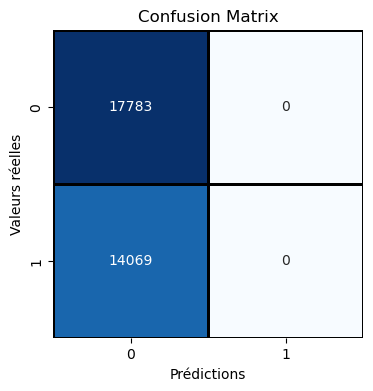

LogisticRegression


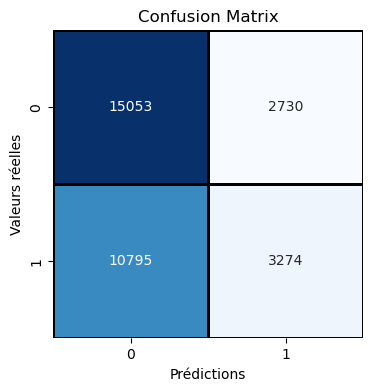

KNeighborsClassifier


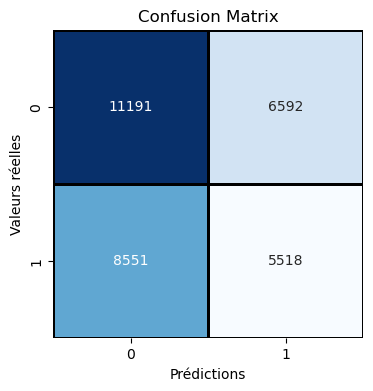

SGDClassifier


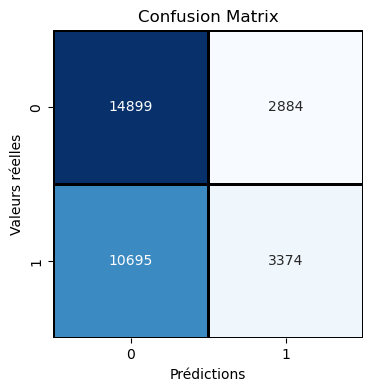

In [80]:
for i in df_prediction:
    print(i)
    matrice_confusion(df_prediction[i])
    

### ROC

DummyClassifier
ROC_AUC = 0.5


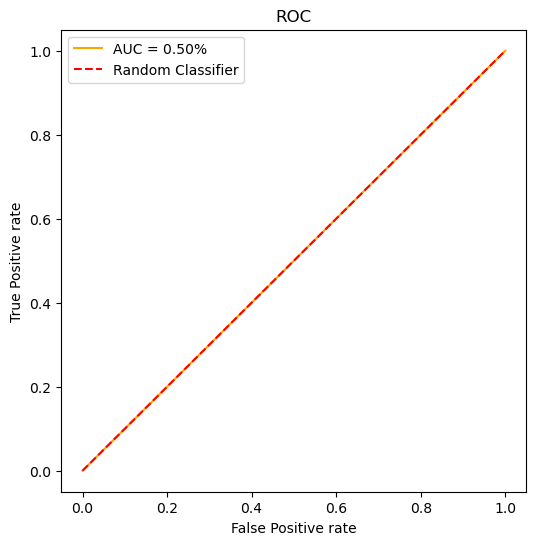

LogisticRegression
ROC_AUC = 0.54


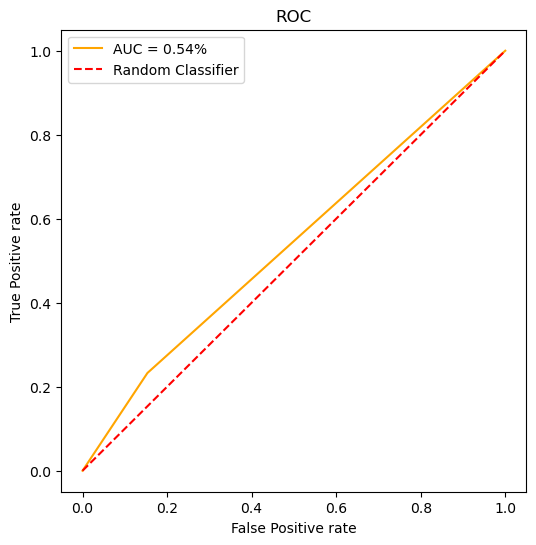

KNeighborsClassifier
ROC_AUC = 0.51


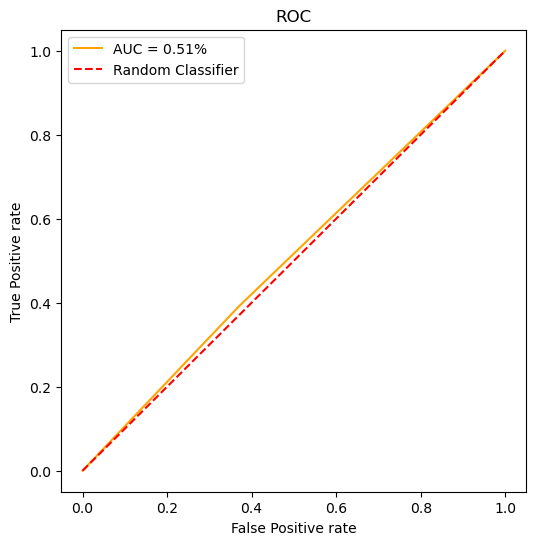

SGDClassifier
ROC_AUC = 0.54


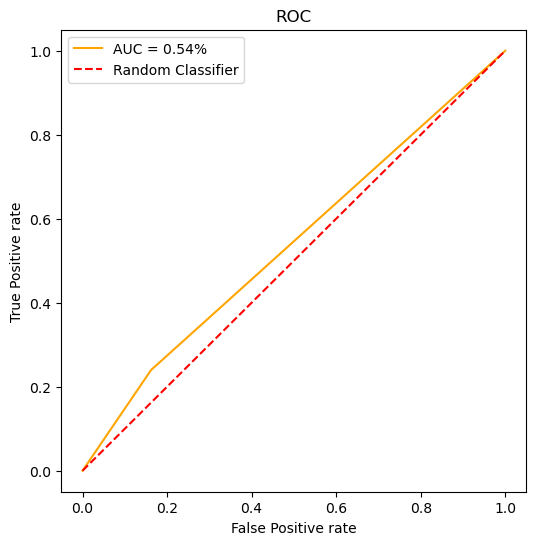

In [81]:
for i in df_prediction:
    print(i)
    ROC(df_prediction[i])
    

### Observation 
- On voit que l'air sous la courbe des modèles entrainé n'est que légèrement meilleur qu'un modèle naïf, et donc que le modèle n'est pas efficace, nous allons essayer de faire un GridSearchCV pour voir si on peut améliorer les modèles

### 5. Amélioration des modèles par Grid

In [82]:
param_grid_LR = { "penalty" : ['l1', 'l2', 'elasticnet']} 

param_grid_knn = {"n_neighbors":np.arange(2,10),
              "metric":["manhattan","euclidean"]
             }
param_grid_SGD = {"loss" : ['hinge', 'log_loss',"squared_error"], "alpha":np.linspace(0,1,5), 
                 "epsilon":np.linspace(0.1,1,4)}

dict_param_grid = [param_grid_knn, param_grid_LR, param_grid_SGD]

In [83]:
models_and_params = [(LogisticRegression(), param_grid_LR), (KNeighborsClassifier(), param_grid_knn), 
                     (SGDClassifier(), param_grid_SGD)
                    ]

#### Recuperation des prédictions et des temps d'execution pour chaque modèles par GRID : 

In [84]:
df_prediction_GRID = pd.DataFrame()
df_time_GRID = pd.DataFrame()
dict_best_estimators = {}
for model, param, in models_and_params:
    prediction, time_execution,best_mod = Grid(model=model,param= param)
    # Récupération du nom du modèle
    model_name = model.__class__.__name__    
    
    #Ajout des prédiction dans le dataframe 
    df_prediction_GRID[model_name] = prediction
    #Ajout des temps d'execution dans le dataframe du temps d'execution
    df_time_GRID[model_name] = pd.Series(time_execution) #mettre en Series pour que la valeur soit acceptée
    
     #ajout du meilleur estimateur dans le dictionnaire : 
    dict_best_estimators[model_name] = best_mod
    

In [85]:
# Récupération du nom du modèle et du chemin d'enregistrement
save_path_grid = r"D:\Etude_Data_science\Kaggle_competition\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\Modeles\Grid"
for i in dict_best_estimators:
    model_name = i
    current_model = dict_best_estimators[model_name]
    model_filename = os.path.join(save_path_grid, f"{model_name}.pkl")
    
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


#### Calcul des différentes metric par GRID

In [86]:
dict_metric_GRID = {}
for prediction,temps in zip(df_prediction_GRID, df_time_GRID):
    nom_model = prediction
    dict_metric_GRID[nom_model] = metric(prediction=df_prediction_GRID[prediction].values,
                                         model_name=prediction, 
                                         exe_time=df_time_GRID[temps].values[0])#permet d'obtenir la valeur 
    #qui ne sera pas une liste


In [87]:
# Concaténation des métriques en un DataFrame
df_metrics_GRID = pd.concat(dict_metric_GRID.values(), axis=1)
#intervertissons les colonnes et les indexs :
df_metrics_GRID = df_metrics_GRID.T


In [88]:
df_metrics_GRID

,F1,accuracy,recall,precision,duree_entrainement(min)
LogisticRegression,0.326209,0.575380,0.232710,0.545303,0.02
KNeighborsClassifier,0.272139,0.540688,0.194399,0.453490,0.03
SGDClassifier,0.582280,0.489640,0.805317,0.455991,5.03


LogisticRegression


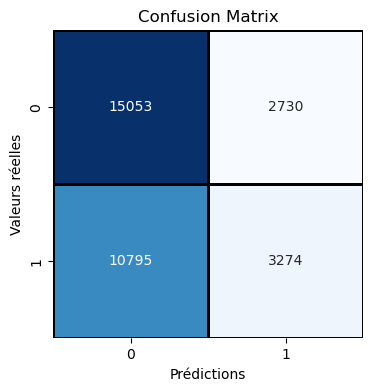

KNeighborsClassifier


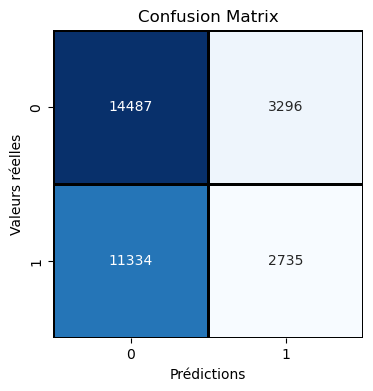

SGDClassifier


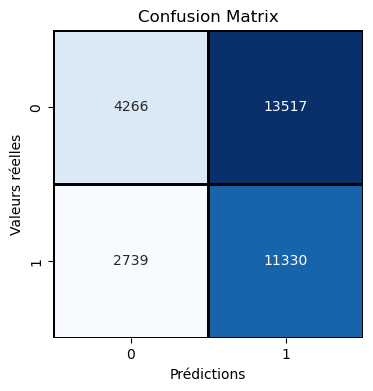

In [89]:
for i in df_prediction_GRID:
    print(i)
    matrice_confusion(df_prediction_GRID[i])

 ### Observation :
 - Les modèles font énormement d'erreur et n'apprennent pas correctement malgrès un GridSearch
 - Il sera peut être préférable d'utiliser l'ensemble des features plutôt qu'une PCA